<a href="https://colab.research.google.com/github/TeinkBR/1D_harmonic_oscillator/blob/main/Test_of_Emulation_for_Infrared_extrapolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
In this notebook, we will explore how to use emulation technology to perform infrared extrapolation. 

# Training calculations
Some codes are from Jingyi's notebook

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
import pickle
#load interactive widgets
import ipywidgets as widgets
from scipy import interpolate
from scipy.special import hermite, gamma, loggamma
from scipy.misc import derivative              # import from scipy derivative 
# Import hermite polynomials and factorial to use in normalization factor
from scipy.special import hermite
#If your screen has retina display this will increase resolution of plots
%config InlineBackend.figure_format = 'retina'
import scipy.integrate as integrate
import scipy.special as special
from numpy import linalg as LA
from scipy.linalg import eigh
%matplotlib inline

In [34]:
class truncation_scheme:
  def __init__(self,mesh,e_max,length, omega, hbar,mass):
  ### input variable 
    
    self.e_max=e_max      

    self.length=length     
    
    self.omega = omega  
    
    self.starting_position=-length/2 
  
    self.ending_position=length/2   
    
    self.mesh=mesh  
    
    self.hbar=hbar 
  
    self.mass=mass 
  
    self.scaling_factor_b=hbar/np.sqrt(mass*omega)
  
    self.meshpoint,self.weight = np.polynomial.legendre.leggauss(mesh) 

    self.meshpoint=self.length/2*self.meshpoint

    self.weight = self.length/2*self.weight

    self.energy_level=np.arange(0,self.e_max) 


In [35]:
class basis_wave_function_class():
  def __init__(self,truncation_scheme):
    self.meshpoint=truncation_scheme.meshpoint
    self.weight = truncation_scheme.weight
    self.energy_level = truncation_scheme.energy_level
    self.e_max = truncation_scheme.e_max
    ### harmonic wave function used for our basis
    self.basis_wave_function_ilevel_ix = np.zeros((self.e_max,len(self.meshpoint)))     
    for i in self.energy_level:
      self.basis_wave_function_ilevel_ix[i]=1./np.sqrt(np.sqrt(np.pi))\
             *np.exp(-0.5*(i*np.log(2) + loggamma(i + 1.) + self.meshpoint**2) ) * hermite(i)(self.meshpoint)


In [36]:
mesh=1000
e_max=60
length=50
omega=1e-10
hbar=197.3
mass=940
alpha=0.5
lambda_coeff=2

In [37]:
truncation_scheme_1 = truncation_scheme(mesh,e_max,length,omega,hbar,mass)

In [38]:
basis_wave_function_1 = basis_wave_function_class(truncation_scheme_1)

In [39]:
### the following is the normalization of the HO's states
for i in truncation_scheme_1.energy_level:
  print(f'the normlization of state {i}: {basis_wave_function_1.basis_wave_function_ilevel_ix[i]**2 @ truncation_scheme_1.weight}')

the normlization of state 0: 1.0000000000001035
the normlization of state 1: 1.0000000000001044
the normlization of state 2: 1.0000000000001044
the normlization of state 3: 1.0000000000001044
the normlization of state 4: 1.0000000000001035
the normlization of state 5: 1.0000000000001048
the normlization of state 6: 1.000000000000105
the normlization of state 7: 1.000000000000105
the normlization of state 8: 1.0000000000001044
the normlization of state 9: 1.0000000000001041
the normlization of state 10: 1.0000000000001046
the normlization of state 11: 1.000000000000104
the normlization of state 12: 1.0000000000001088
the normlization of state 13: 1.0000000000001084
the normlization of state 14: 1.0000000000001017
the normlization of state 15: 1.0000000000000986
the normlization of state 16: 1.000000000000104
the normlization of state 17: 1.0000000000001
the normlization of state 18: 1.000000000000108
the normlization of state 19: 1.0000000000001044
the normlization of state 20: 1.000000

In [40]:
class Hamiltonian_class:
  def __init__(self,truncation_scheme, omega_T, V_s_func_of_x_unscaled,test_r_sqr_included=False):  
    ### setting Hamiltonian Numerical space
    ### Kinetic term + Potential Term + Harmonic oscillator trap
    self.truncation_scheme = truncation_scheme 
    self.omega_T = omega_T
    self.hbar = truncation_scheme.hbar
    self.mass = truncation_scheme.mass
    self.omega = truncation_scheme.omega 
    self.meshpoint=truncation_scheme.meshpoint
    self.weight = truncation_scheme.weight
    self.energy_level = truncation_scheme.energy_level
    self.e_max = truncation_scheme.e_max
    self.basis_wave_function_ilevel_ix  = basis_wave_function_class(truncation_scheme).basis_wave_function_ilevel_ix
    self.scaling_factor_b= truncation_scheme.scaling_factor_b 

    self.H_p_sqr=np.zeros((self.e_max,self.e_max))
    self.H_r_sqr=np.zeros((self.e_max,self.e_max))

    ## this is the potential on the x mesh after rescsling
    self.V_s_ix = np.array([ V_s_func_of_x_unscaled(x*self.scaling_factor_b)/self.omega 
                            for x in self.meshpoint]) 
    
    self.V_s_ilevel_ilevel = [[(self.weight*self.basis_wave_function_ilevel_ix[i] 
                                * self.V_s_ix) 
                                       @(self.basis_wave_function_ilevel_ix[j])  
                              for j in self.energy_level]  
                              for i in self.energy_level]
    
  ### integration using numerical gaussian quadrature 

   ### Now we set Hamiltonian P square and R square values from the book of Quantum Mechanics By Griffith     
   ### i & j here are the energy level of the psi and psi conjugate <psi|H|psi>, formula from the textbook 
   ### mentioned above, see overleaf file

    for i in range(self.e_max):
     for j in range(self.e_max):   
        if (i == j) :
          self.H_p_sqr[i][j]= 0.25*(2*j+1)
          self.H_r_sqr[i][j] = 0.25*(2*j+1)
          
        elif (i == j-2):
           
          self.H_p_sqr[i][j]= -0.25*np.sqrt(j*(j-1))
          self.H_r_sqr[i][j] = 0.25*np.sqrt(j*(j-1))

            
        elif (i == j+2):
           
          self.H_p_sqr[i][j]= -0.25*np.sqrt((j+2)*(j+1))
          self.H_r_sqr[i][j] = 0.25*np.sqrt((j+2)*(j+1))
            
        else:
          
          self.H_p_sqr[i][j]=  0
          self.H_r_sqr[i][j]=  0

     ### Total H include Potential V + Kinetic T + Harmonic Oscillator Trap R_squared
    if (test_r_sqr_included == False):
      self.Total_H= self.V_s_ilevel_ilevel +self.H_p_sqr
    else:  
      self.Total_H= self.V_s_ilevel_ilevel +self.H_p_sqr+self.H_r_sqr*(self.omega_T/self.omega)**2
   
     ### getting eigenvalue(energy) and eigenvector(wavefunction) from the hamiltonian
    self.eigenval_iHlevel,self.psi_iHOlevel_iHlevel = LA.eigh(self.Total_H)
     ### same thing, but computed from numerical Total H, might not be useful
    
     ## <Phi|psi>, for plotting
    self.psi_iHlevel_ix = self.psi_iHOlevel_iHlevel.T @ self.basis_wave_function_ilevel_ix

    

Define the strong interaction potential function

In [41]:
class PT_pot_class:
  def __init__(self, hbar, mass, alpha, lambda_coeff):
    self.hbar = hbar 
    self.mass = mass 
    self.alpha = alpha 
    self.lambda_coeff= lambda_coeff 
    self.eigenE_ifullH_analy = - (self.hbar*self.alpha*(self.lambda_coeff-1-np.arange(0,e_max)))**2/(2*self.mass)

  def V_s_func_of_x_unscaled(self, x):
    return  -(self.alpha*self.hbar)**2/(2*self.mass) *self.lambda_coeff*(
      self.lambda_coeff-1)/(np.cosh(self.alpha* x )**2)

In [42]:
alpha, lambda_coeff

(0.5, 2)

In [43]:
x_unscaled_list = np.linspace(-5,5,100)
PT_pot_1 = PT_pot_class(hbar, mass, alpha, lambda_coeff)

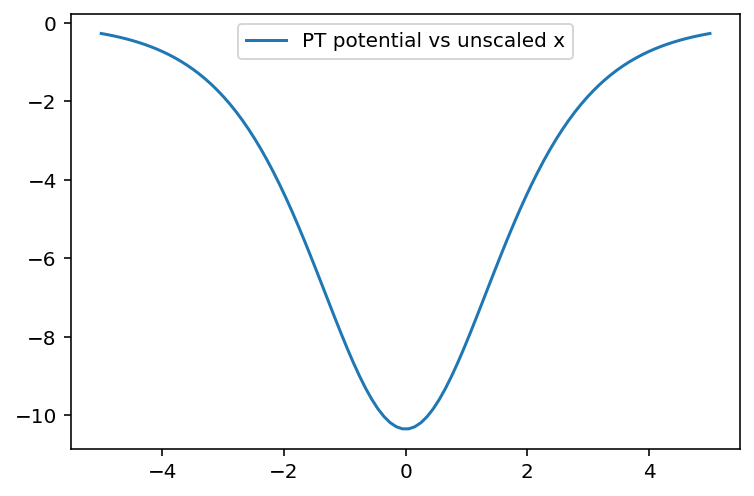

In [44]:
plt.plot(x_unscaled_list, PT_pot_1.V_s_func_of_x_unscaled(x_unscaled_list) , label = 'PT potential vs unscaled x')
plt.legend(loc = 'best')
plt.show()

# Test the training calculations codes for PT potential 

In [45]:
omega_T = 1e-10 
H_class_for_PT_pot_1  =  Hamiltonian_class(truncation_scheme_1 , omega_T , PT_pot_1.V_s_func_of_x_unscaled,test_r_sqr_included=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in cosh
  # This is added back by InteractiveShellApp.init_path()


In [46]:
H_class_for_PT_pot_1.eigenval_iHlevel*omega 

array([5.00e-11, 1.50e-10, 2.50e-10, 3.50e-10, 4.50e-10, 5.50e-10,
       6.50e-10, 7.50e-10, 8.50e-10, 9.50e-10, 1.05e-09, 1.15e-09,
       1.25e-09, 1.35e-09, 1.45e-09, 1.55e-09, 1.65e-09, 1.75e-09,
       1.85e-09, 1.95e-09, 2.05e-09, 2.15e-09, 2.25e-09, 2.35e-09,
       2.45e-09, 2.55e-09, 2.65e-09, 2.75e-09, 2.85e-09, 2.95e-09,
       3.05e-09, 3.15e-09, 3.25e-09, 3.35e-09, 3.45e-09, 3.55e-09,
       3.65e-09, 3.75e-09, 3.85e-09, 3.95e-09, 4.05e-09, 4.15e-09,
       4.25e-09, 4.35e-09, 4.45e-09, 4.55e-09, 4.65e-09, 4.75e-09,
       4.85e-09, 4.95e-09, 5.05e-09, 5.15e-09, 5.25e-09, 5.35e-09,
       5.45e-09, 5.55e-09, 5.65e-09, 5.75e-09, 5.85e-09, 5.95e-09])

In [47]:
PT_pot_1.eigenE_ifullH_analy

array([-5.17650133e+00, -0.00000000e+00, -5.17650133e+00, -2.07060053e+01,
       -4.65885120e+01, -8.28240213e+01, -1.29412533e+02, -1.86354048e+02,
       -2.53648565e+02, -3.31296085e+02, -4.19296608e+02, -5.17650133e+02,
       -6.26356661e+02, -7.45416191e+02, -8.74828725e+02, -1.01459426e+03,
       -1.16471280e+03, -1.32518434e+03, -1.49600888e+03, -1.67718643e+03,
       -1.86871698e+03, -2.07060053e+03, -2.28283709e+03, -2.50542664e+03,
       -2.73836920e+03, -2.98166477e+03, -3.23531333e+03, -3.49931490e+03,
       -3.77366947e+03, -4.05837704e+03, -4.35343762e+03, -4.65885120e+03,
       -4.97461778e+03, -5.30073736e+03, -5.63720995e+03, -5.98403554e+03,
       -6.34121413e+03, -6.70874572e+03, -7.08663032e+03, -7.47486792e+03,
       -7.87345852e+03, -8.28240213e+03, -8.70169874e+03, -9.13134835e+03,
       -9.57135096e+03, -1.00217066e+04, -1.04824152e+04, -1.09534768e+04,
       -1.14348914e+04, -1.19266591e+04, -1.24287797e+04, -1.29412533e+04,
       -1.34640800e+04, -

In [48]:
e_max_list = np.arange(20,100,20) 
omega_list = np.arange(1,110,2) 
gs_E_iemax_iomega = np.zeros((len(e_max_list), len(omega_list)))

for iemax, e_max in enumerate(e_max_list):
  for iomega, omega in enumerate(omega_list): 
    truncation_scheme_tp = truncation_scheme(mesh,e_max,length,omega,hbar,mass)
    omega_T = 0 
    H_class_for_PT_pot_tp  =  Hamiltonian_class(truncation_scheme_tp , omega_T, PT_pot_1.V_s_func_of_x_unscaled,test_r_sqr_included=True)
    gs_E_iemax_iomega[iemax, iomega] = H_class_for_PT_pot_tp.eigenval_iHlevel[0]*omega 


/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:128: RuntimeWarning: invalid value encountered in sqrt
  mu = sqrt(hn)


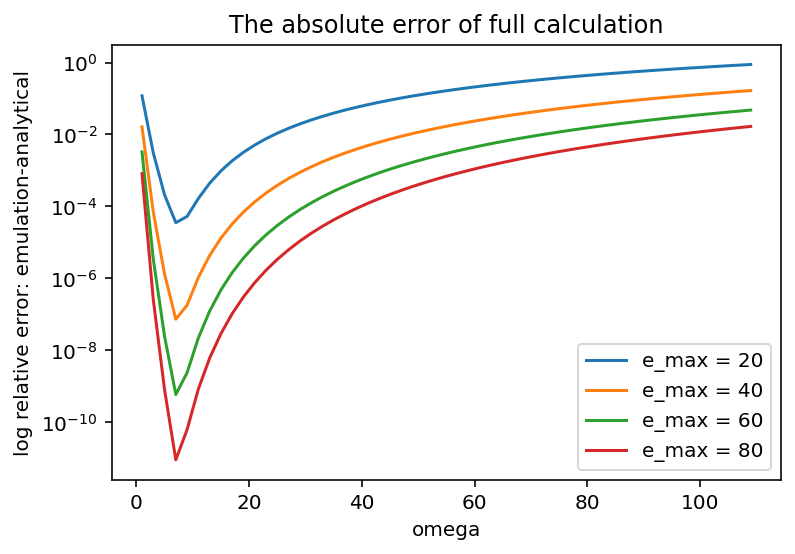

In [49]:
for iemax, e_max in enumerate(e_max_list):
  plt.plot(omega_list, np.absolute(gs_E_iemax_iomega[iemax]-PT_pot_1.eigenE_ifullH_analy[0]), label = f'e_max = {e_max}' )

plt.yscale('log')
plt.xlabel('omega')
plt.ylabel('log relative error: emulation-analytical')
plt.title('The absolute error of full calculation')
plt.legend()

plt.show()

# Construct a list of training Hamiltonian classes based on PT potential



In [50]:
omega_training_list = np.linspace(20,21,3)
e_max_training = 20 
print(f'length={length}, mesh= {mesh}')

length=50, mesh= 1000


In [51]:
alpha = 0.5 
lambda_coeff = 2 
PT_pot_1 = PT_pot_class(hbar, mass, alpha, lambda_coeff)

In [52]:
H_class_training_list =  []
for omega in omega_training_list : 
  truncation_scheme_tp = truncation_scheme(mesh,e_max_training,length,omega,hbar,mass)
  H_class_training_list.append(Hamiltonian_class(truncation_scheme_tp, omega, PT_pot_1.V_s_func_of_x_unscaled,test_r_sqr_included=True) )

# Emulation

In [53]:
class emulation:
  def __init__(self,training_list):
    
    self.training_list = training_list     
    self.hbar= self.training_list[0].hbar
    self.mass=self.training_list[0].mass
    self.e_max=self.training_list[0].e_max
    self.meshpoint= self.training_list[0].meshpoint
    self.weight = self.training_list[0].weight
    self.basis_wave_function_ilevel_ix = self.training_list[0].basis_wave_function_ilevel_ix 
    self.energy_level = self.training_list[0].energy_level
    self.N_matrix=[[np.conj(
            class_left.psi_iHOlevel_iHlevel[:,0]) @ class_right.psi_iHOlevel_iHlevel[:, 0] 
            for j, class_right in enumerate(self.training_list)] 
            for i,class_left in enumerate(self.training_list)]

    ## The sum of the p^2 and r^2 pieces in H
    self.H_p_sqr_r_sqr_ilevel_ilevel = training_list[0].H_p_sqr+ training_list[0].H_r_sqr

  def start_emu(self,emulation_omega, emulation_V_s_func_of_x_unscaled):
    ## this is the potential on the x mesh after rescsling
    scaling_factor_b = self.hbar/np.sqrt(mass*emulation_omega)
    V_s_ix = np.array([ emulation_V_s_func_of_x_unscaled(x*scaling_factor_b)/emulation_omega 
                            for x in self.meshpoint]) 
    
    V_s_ilevel_ilevel = [[(self.weight*self.basis_wave_function_ilevel_ix[i] 
                                * V_s_ix) 
                                       @(self.basis_wave_function_ilevel_ix[j])  
                              for j in self.energy_level]  
                              for i in self.energy_level]

    emulation_H= self.H_p_sqr_r_sqr_ilevel_ilevel + V_s_ilevel_ilevel

    self.H_matrix=[[np.conj(
            class_left.psi_iHOlevel_iHlevel[:,0]) @ emulation_H @ class_right.psi_iHOlevel_iHlevel[:, 0] 
            for j, class_right in enumerate(self.training_list)] 
            for i,class_left in enumerate(self.training_list)]
    
    eigval_emu_H, eigvec_emu_H = eigh(self.H_matrix,self.N_matrix)
      
    
    
    return eigval_emu_H,eigvec_emu_H, V_s_ix

In [54]:
my_emul = emulation(H_class_training_list)

In [55]:
emulation_omega_list = np.arange(1,100, 1)
emulation_V_s_func_of_x_unscaled = PT_pot_1.V_s_func_of_x_unscaled
emulation_gs_E_list = emulation_omega_list * 0. 
gs_E_from_fullcalculation_list = emulation_gs_E_list + 1.
V_s_ix_iemu = [] 
e_max_for_fullcalclation = e_max_training + 20
for i, emulation_omega in enumerate(emulation_omega_list) : 
  eigval_emu_H,eigvec_emu_H, V_s_ix  = my_emul.start_emu(emulation_omega, emulation_V_s_func_of_x_unscaled)
  emulation_gs_E_list[i] = eigval_emu_H[0]*emulation_omega
  V_s_ix_iemu.append(V_s_ix)
  omega = 20
  truncation_scheme_tp = truncation_scheme(mesh,e_max_for_fullcalclation,length,omega,hbar,mass)
  gs_E_from_fullcalculation_list[i]= Hamiltonian_class(truncation_scheme_tp,emulation_omega, PT_pot_1.V_s_func_of_x_unscaled,test_r_sqr_included=True).eigenval_iHlevel[0]*omega   


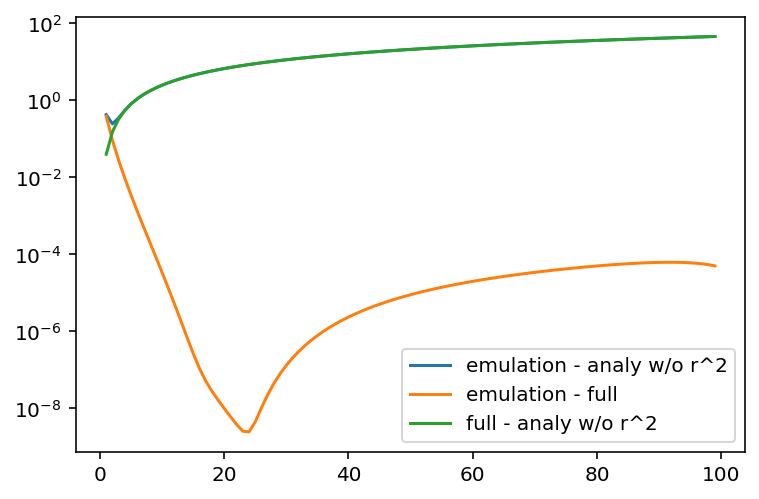

In [56]:
plt.plot(emulation_omega_list, np.absolute(emulation_gs_E_list - PT_pot_1.eigenE_ifullH_analy[0]), label = 'emulation - analy w/o r^2')
plt.plot(emulation_omega_list, np.absolute(emulation_gs_E_list - gs_E_from_fullcalculation_list), label = 'emulation - full')
plt.plot(emulation_omega_list, np.absolute(gs_E_from_fullcalculation_list- PT_pot_1.eigenE_ifullH_analy[0]), label = 'full - analy w/o r^2')
plt.legend()
plt.yscale('log')
plt.show()

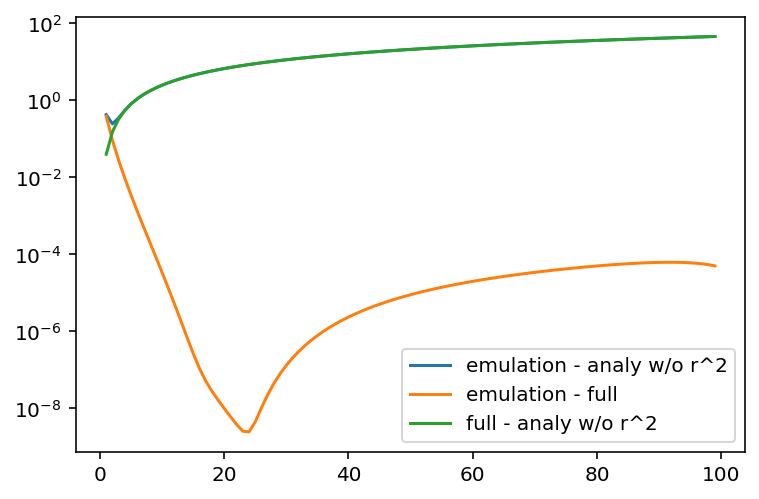

In [57]:
plt.plot(emulation_omega_list, np.absolute(emulation_gs_E_list - PT_pot_1.eigenE_ifullH_analy[0]), label = 'emulation - analy w/o r^2')
plt.plot(emulation_omega_list, np.absolute(emulation_gs_E_list - gs_E_from_fullcalculation_list), label = 'emulation - full')
plt.plot(emulation_omega_list, np.absolute(gs_E_from_fullcalculation_list- PT_pot_1.eigenE_ifullH_analy[0]), label = 'full - analy w/o r^2')
plt.legend()
plt.yscale('log')
plt.show()

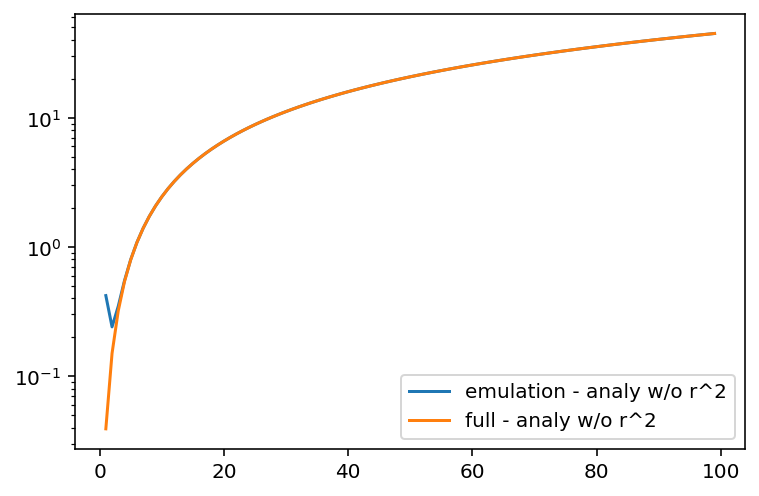

In [58]:
plt.plot(emulation_omega_list, np.absolute(emulation_gs_E_list - PT_pot_1.eigenE_ifullH_analy[0]), label = 'emulation - analy w/o r^2')
plt.plot(emulation_omega_list, np.absolute(gs_E_from_fullcalculation_list- PT_pot_1.eigenE_ifullH_analy[0]), label = 'full - analy w/o r^2')
plt.legend()
plt.yscale('log')
plt.show()

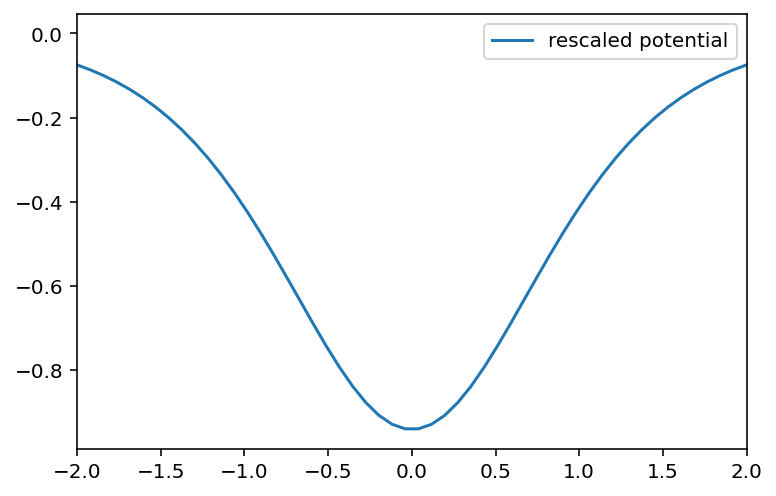

In [59]:
plt.plot(truncation_scheme_1.meshpoint, V_s_ix_iemu[10], label = 'rescaled potential')
plt.xlim(-2,2)
plt.legend()
plt.show()

Here I perform trainings in two-dim parameter space, including omega, and lambda_c

In [60]:
para_training_list = [[20.5, .5],   [20.5, 3],   [30.5, 0.5],  [30.5, 1.5],   [30.5, 3]    ]
e_max_training = 40 

In [61]:
H_class_training_list_2 =  []
for para in para_training_list : 
  omega_tp = para[0]
  lambda_coeff_tp = para[1]
  truncation_scheme_tp = truncation_scheme(mesh,e_max_training,length,omega_tp,hbar,mass)
  PT_pot_tp = PT_pot_class(hbar, mass, alpha, lambda_coeff_tp)
  H_class_training_list_2.append(Hamiltonian_class(truncation_scheme_tp, omega_T,PT_pot_tp.V_s_func_of_x_unscaled, test_r_sqr_included=True) )

In [62]:
my_emul_2 = emulation(H_class_training_list_2)

In [63]:
emulation_omega_list = np.arange(1,100, 1)
lambda_coeff = 2 
print(f'alpha={alpha}, lambda_coeff = {lambda_coeff}')
PT_pot_1 = PT_pot_class(hbar, mass, alpha, lambda_coeff)
emulation_V_s_func_of_x_unscaled = PT_pot_1.V_s_func_of_x_unscaled
emulation_gs_E_list_2 = emulation_omega_list * 0. 
e_max_for_fullcalclation = e_max_training
for i, emulation_omega in enumerate(emulation_omega_list) : 
  eigval_emu_H,eigvec_emu_H, V_s_ix  = my_emul_2.start_emu(emulation_omega, emulation_V_s_func_of_x_unscaled)
  emulation_gs_E_list_2[i] = eigval_emu_H[0]*emulation_omega

alpha=0.5, lambda_coeff = 2


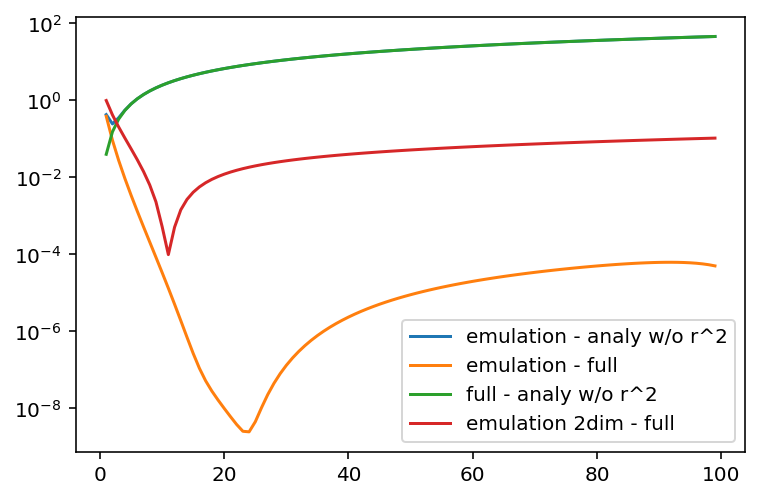

In [64]:
plt.plot(emulation_omega_list, np.absolute(emulation_gs_E_list - PT_pot_1.eigenE_ifullH_analy[0]), label = 'emulation - analy w/o r^2')
plt.plot(emulation_omega_list, np.absolute(emulation_gs_E_list - gs_E_from_fullcalculation_list), label = 'emulation - full')
plt.plot(emulation_omega_list, np.absolute(gs_E_from_fullcalculation_list- PT_pot_1.eigenE_ifullH_analy[0]), label = 'full - analy w/o r^2')
plt.plot(emulation_omega_list, np.absolute(emulation_gs_E_list_2- gs_E_from_fullcalculation_list), label = 'emulation 2dim - full')
plt.legend()
plt.yscale('log')
plt.show()